In [15]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [16]:
# Read and print the first 10 lines of train.txt
# with open("../Data/dac/train.txt", "r") as file:
#     for _ in range(10):
#         print(file.readline().strip())  # .strip() removes trailing newlines

In [17]:
import pandas as pd

# Define column names
label_col = ["label"]
int_feature_cols = [f"I{i}" for i in range(1, 14)]
cat_feature_cols = [f"C{i}" for i in range(1, 27)]
train_columns = label_col + int_feature_cols + cat_feature_cols
test_columns = int_feature_cols + cat_feature_cols  # No label in test set


# Convert train.txt to train.csv
df_train = pd.read_csv(
    "../Data/dac/train.txt", delimiter="\t", names=train_columns, 
    header=None, nrows=1000, dtype={col: "Int64" for col in int_feature_cols}
)
df_train.to_csv("../Data/dac/train.csv", index=False)
df_train = pd.read_csv("../Data/dac/train.csv", dtype={col: "Int64" for col in int_feature_cols})  # Adjust delimiter if needed


# Convert test.txt to test.csv
df_test = pd.read_csv(
    "../Data/dac/test.txt", delimiter="\t", names=test_columns, 
    header=None, nrows=100, dtype={col: "Int64" for col in int_feature_cols}
)
df_test.to_csv("../Data/dac/test.csv", index=False)
df_test = pd.read_csv("../Data/dac/test.csv", dtype={col: "Int64" for col in int_feature_cols})  # Adjust delimiter if needed

df_all = pd.concat([df_train, df_test],axis=0)
df_all = df_all.reset_index(drop=True)

In [26]:
# display(df_all.info())
# display(df_all.head().T)
# display(df_all.describe().T)
# display(df_all.isnull().sum().T)
# print('all shape:', df_all.shape)

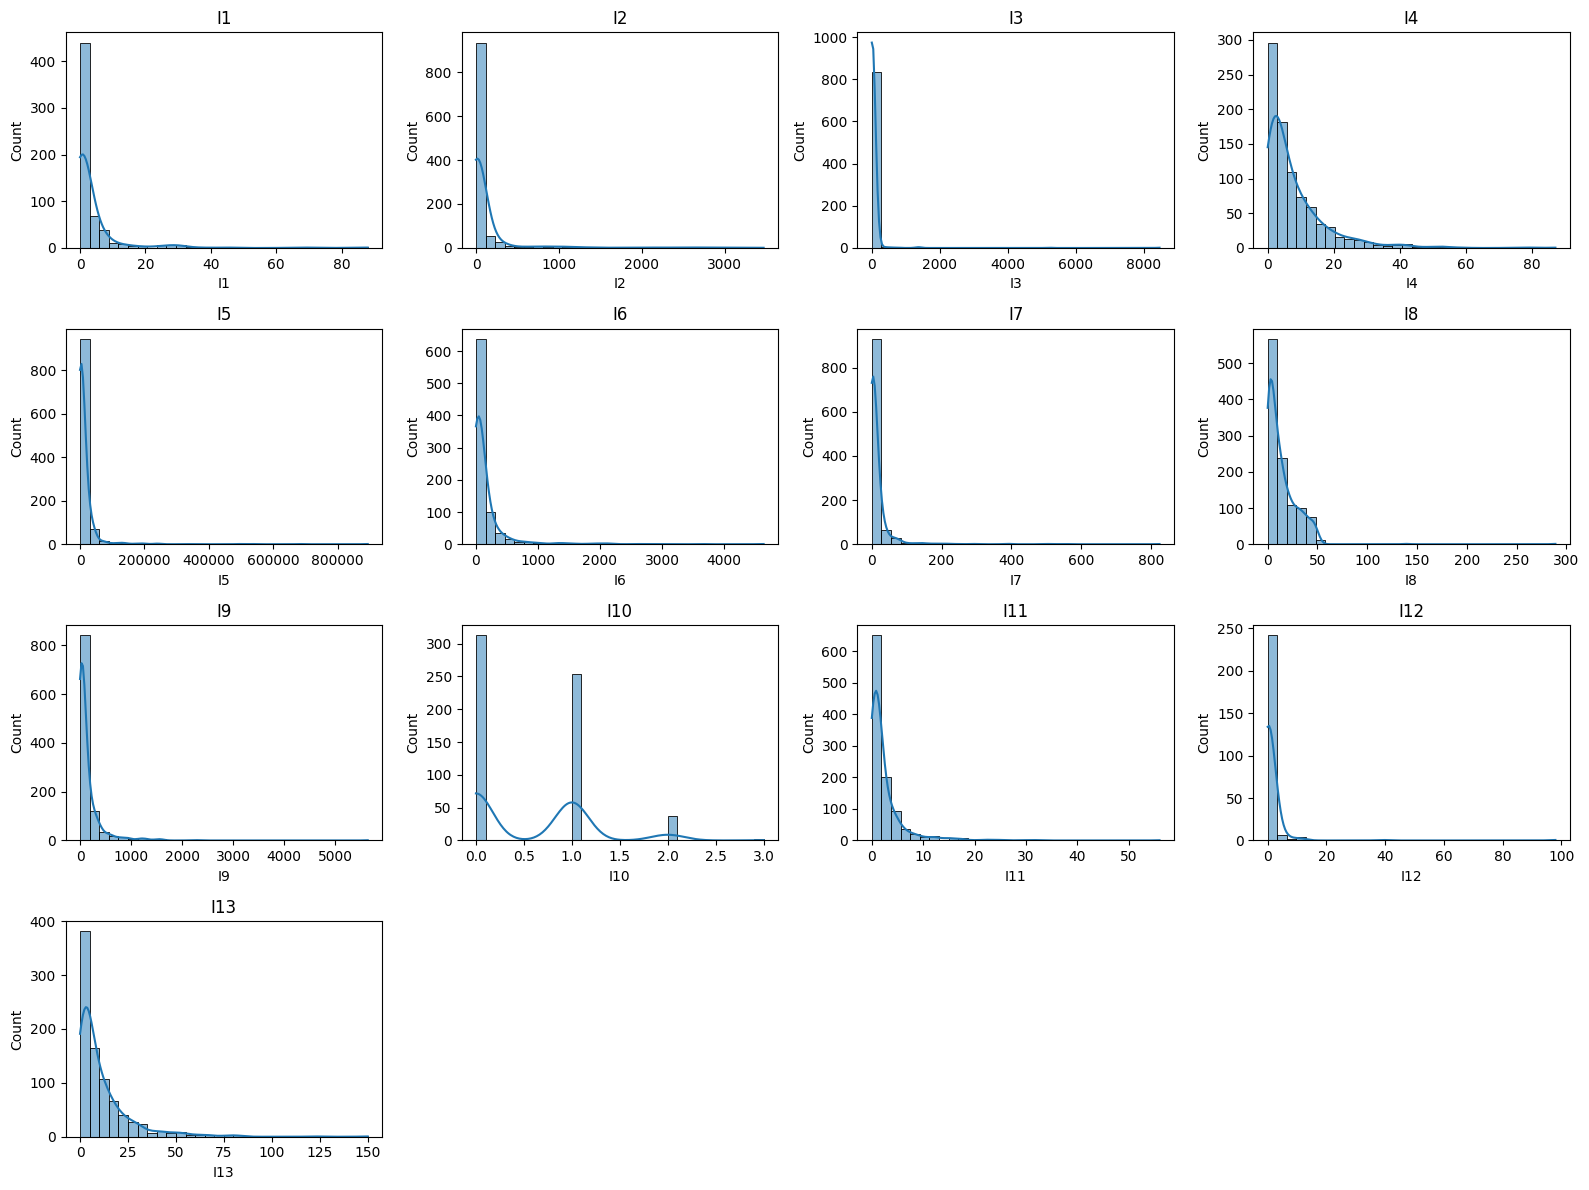

In [19]:
# Convert integer columns to numeric (handling missing values)
df_all[int_feature_cols] = df_all[int_feature_cols].apply(pd.to_numeric, errors='coerce')
# Set up the plot grid
fig, axes = plt.subplots(4, 4, figsize=(16, 12))  # 4x4 grid, one extra empty plot
axes = axes.flatten()

# Plot histograms for each integer column
for i, col in enumerate(int_feature_cols):
    sns.histplot(df_all[col].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# Hide any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [20]:
# Replace Outlier with whiskers for I1 - I13

# Function to cap outliers based on Tukey's fences
def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_whisker = 0
        upper_whisker = int(Q3 + 1.5 * IQR)
        
        df[col] = df[col].clip(lower=lower_whisker, upper=upper_whisker)
    return df
integer_columns = ["I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", "I10", "I11", "I12", "I13"]
df_all = cap_outliers(df_all, integer_columns)


In [21]:
# Treat the following Integer Columns as Categorical Features: I1 & I10, I11, I12
    # Binning the values
    # I1:   -1: missing
        #    0: 0 <=I1 <2
        #    1: 2 <=I1 <4
        #    2: 4 <= I1 
    # I10:  -1: missing
        #    0: 0
        #    1: 1
        #    2: 2
    # I11:  replace missing with median value first
        #    0: 0 <=I11 <2
        #    1: 2 <=I11 <4
        #    2: 4 <= I11 
    # I12:  -1: missing
        #    0: 0
        #    1: 1
        #    2: 2

# replace missing values with -1 for I1, I10, and I12
missing_cols = ["I1", "I10", "I12"]
df_all[missing_cols] = df_all[missing_cols].fillna(-1)  # Fill with -1 as placeholder

# replace missing values with median for I11
df_all["I11"] = pd.to_numeric(df_all["I11"], errors="coerce")  # Convert to numeric
df_all["I11"] = df_all["I11"].fillna(df_all["I11"].median())  # Fill with median


# Binning for each of them
def bin_values(df):
    df["I1"] = pd.cut(df["I1"], bins=[-2, -1, 2, 4, float('inf')], labels=[-1, 0, 1, 2])
    df["I10"] = df["I10"].map({0: 0, 1: 1, 2: 2}).fillna(-1)
    df["I11"] = pd.cut(df["I11"], bins=[-float('inf'), 2, 4, float('inf')], labels=[0, 1, 2])
    df["I12"] = df["I12"].map({0: 0, 1: 1, 2: 2}).fillna(-1)
    return df
df_all = bin_values(df_all)




# Treat the following Integer Columns as Integer Features: I2 - I9, I13
        #  Replace missing with median
        #  Log transform 
missing_cols = ["I2","I3","I4","I5","I6","I7","I8","I9","I13"]
# df_all[missing_cols] = df_all[missing_cols].fillna(df_all[missing_cols].median())
df_all[missing_cols] = df_all[missing_cols].astype(float).fillna(df_all[missing_cols].median())


# Function to apply log transformation
def log_transform(df, cols):
    for col in cols:
        df[col] = np.log1p(df[col])   # log1p to handle zero values safely
    return df
log_columns = ["I2","I3","I4","I6","I7","I8","I13"]  # no "I5", "I9"
df_all = log_transform(df_all, log_columns)

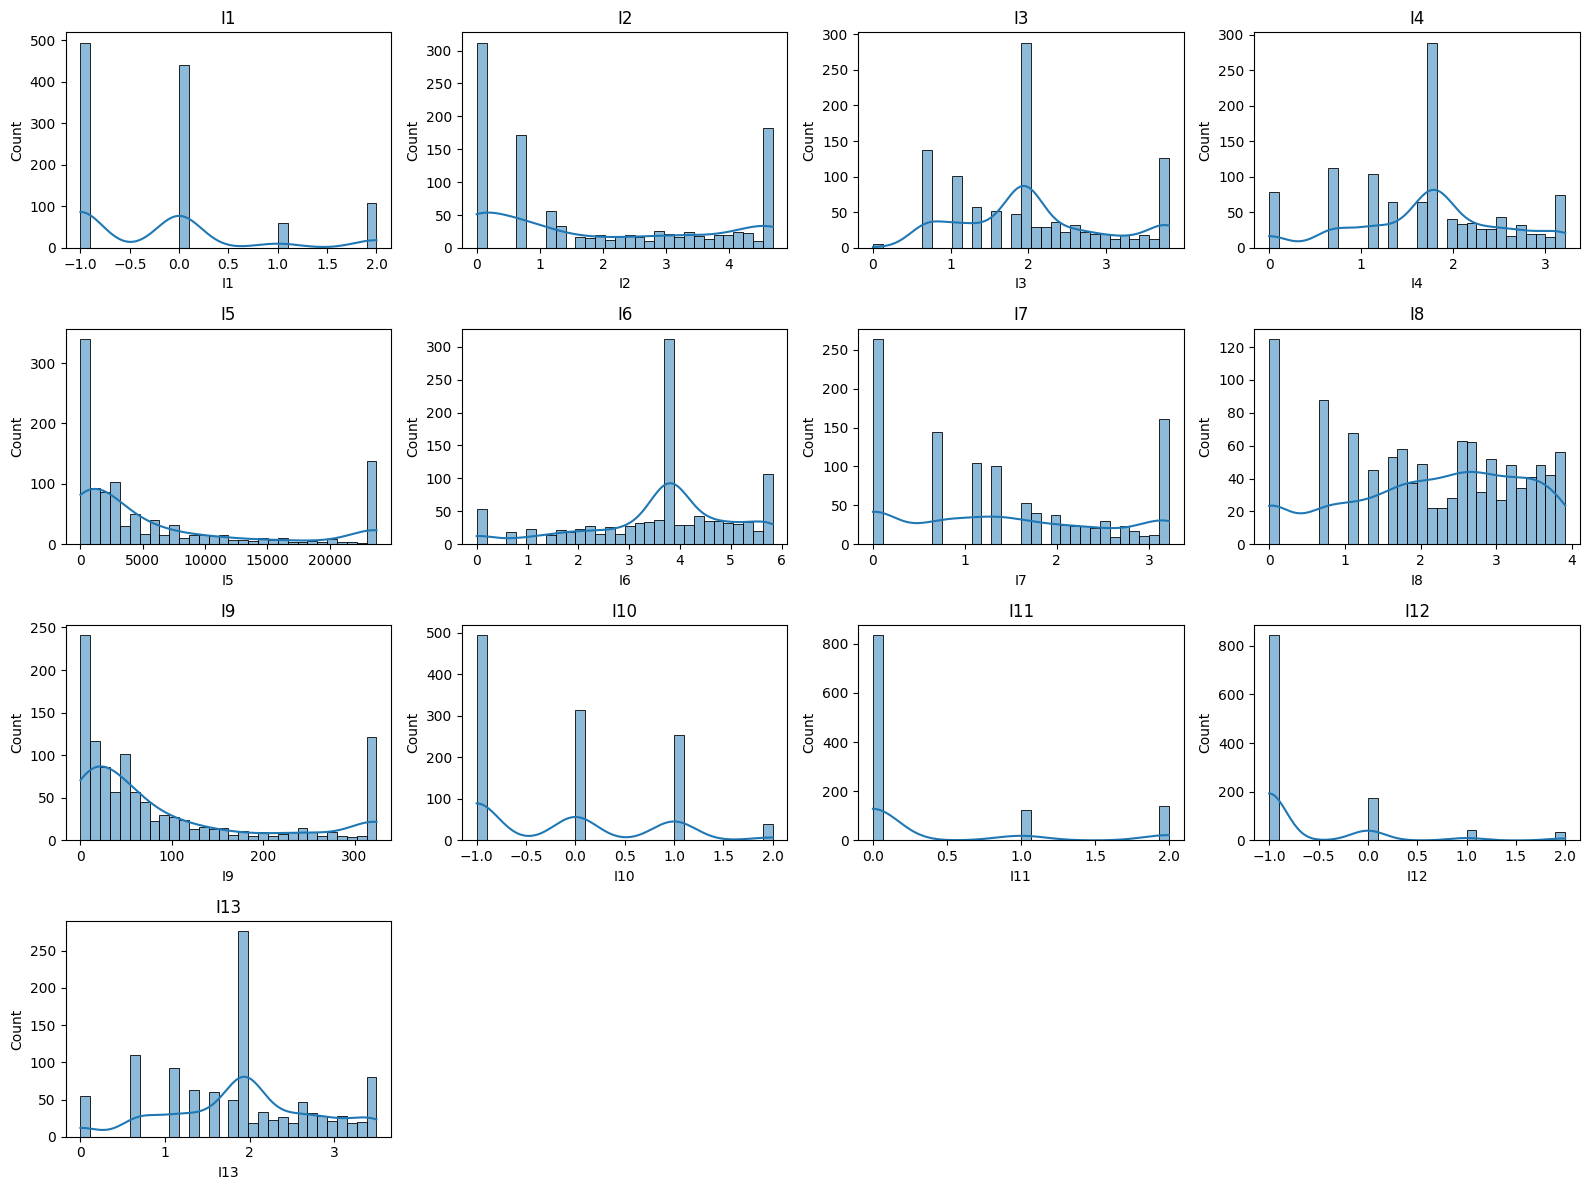

In [22]:
# Convert integer columns to numeric (handling missing values)
df_all[int_feature_cols] = df_all[int_feature_cols].apply(pd.to_numeric, errors='coerce')
# Set up the plot grid
fig, axes = plt.subplots(4, 4, figsize=(16, 12))  # 4x4 grid, one extra empty plot
axes = axes.flatten()

# Plot histograms for each integer column
for i, col in enumerate(int_feature_cols):
    sns.histplot(df_all[col].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# Hide any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [29]:
# display(df_all.info())
# display(df_all.head().T)
# display(df_all.describe().T)
# display(df_all.isnull().sum().T)
# print('all shape:', df_all.shape)

In [38]:
# Categorical Variables C1-C26
for i in range(1,27):
    print(f"C{i}: ", df_all[f"C{i}"].nunique())

C1:  55
C2:  198
C3:  726
C4:  612
C5:  23
C6:  7
C7:  751
C8:  28
C9:  2
C10:  577
C11:  644
C12:  700
C13:  586
C14:  15
C15:  554
C16:  670
C17:  9
C18:  379
C19:  129
C20:  4
C21:  685
C22:  6
C23:  12
C24:  451
C25:  29
C26:  351


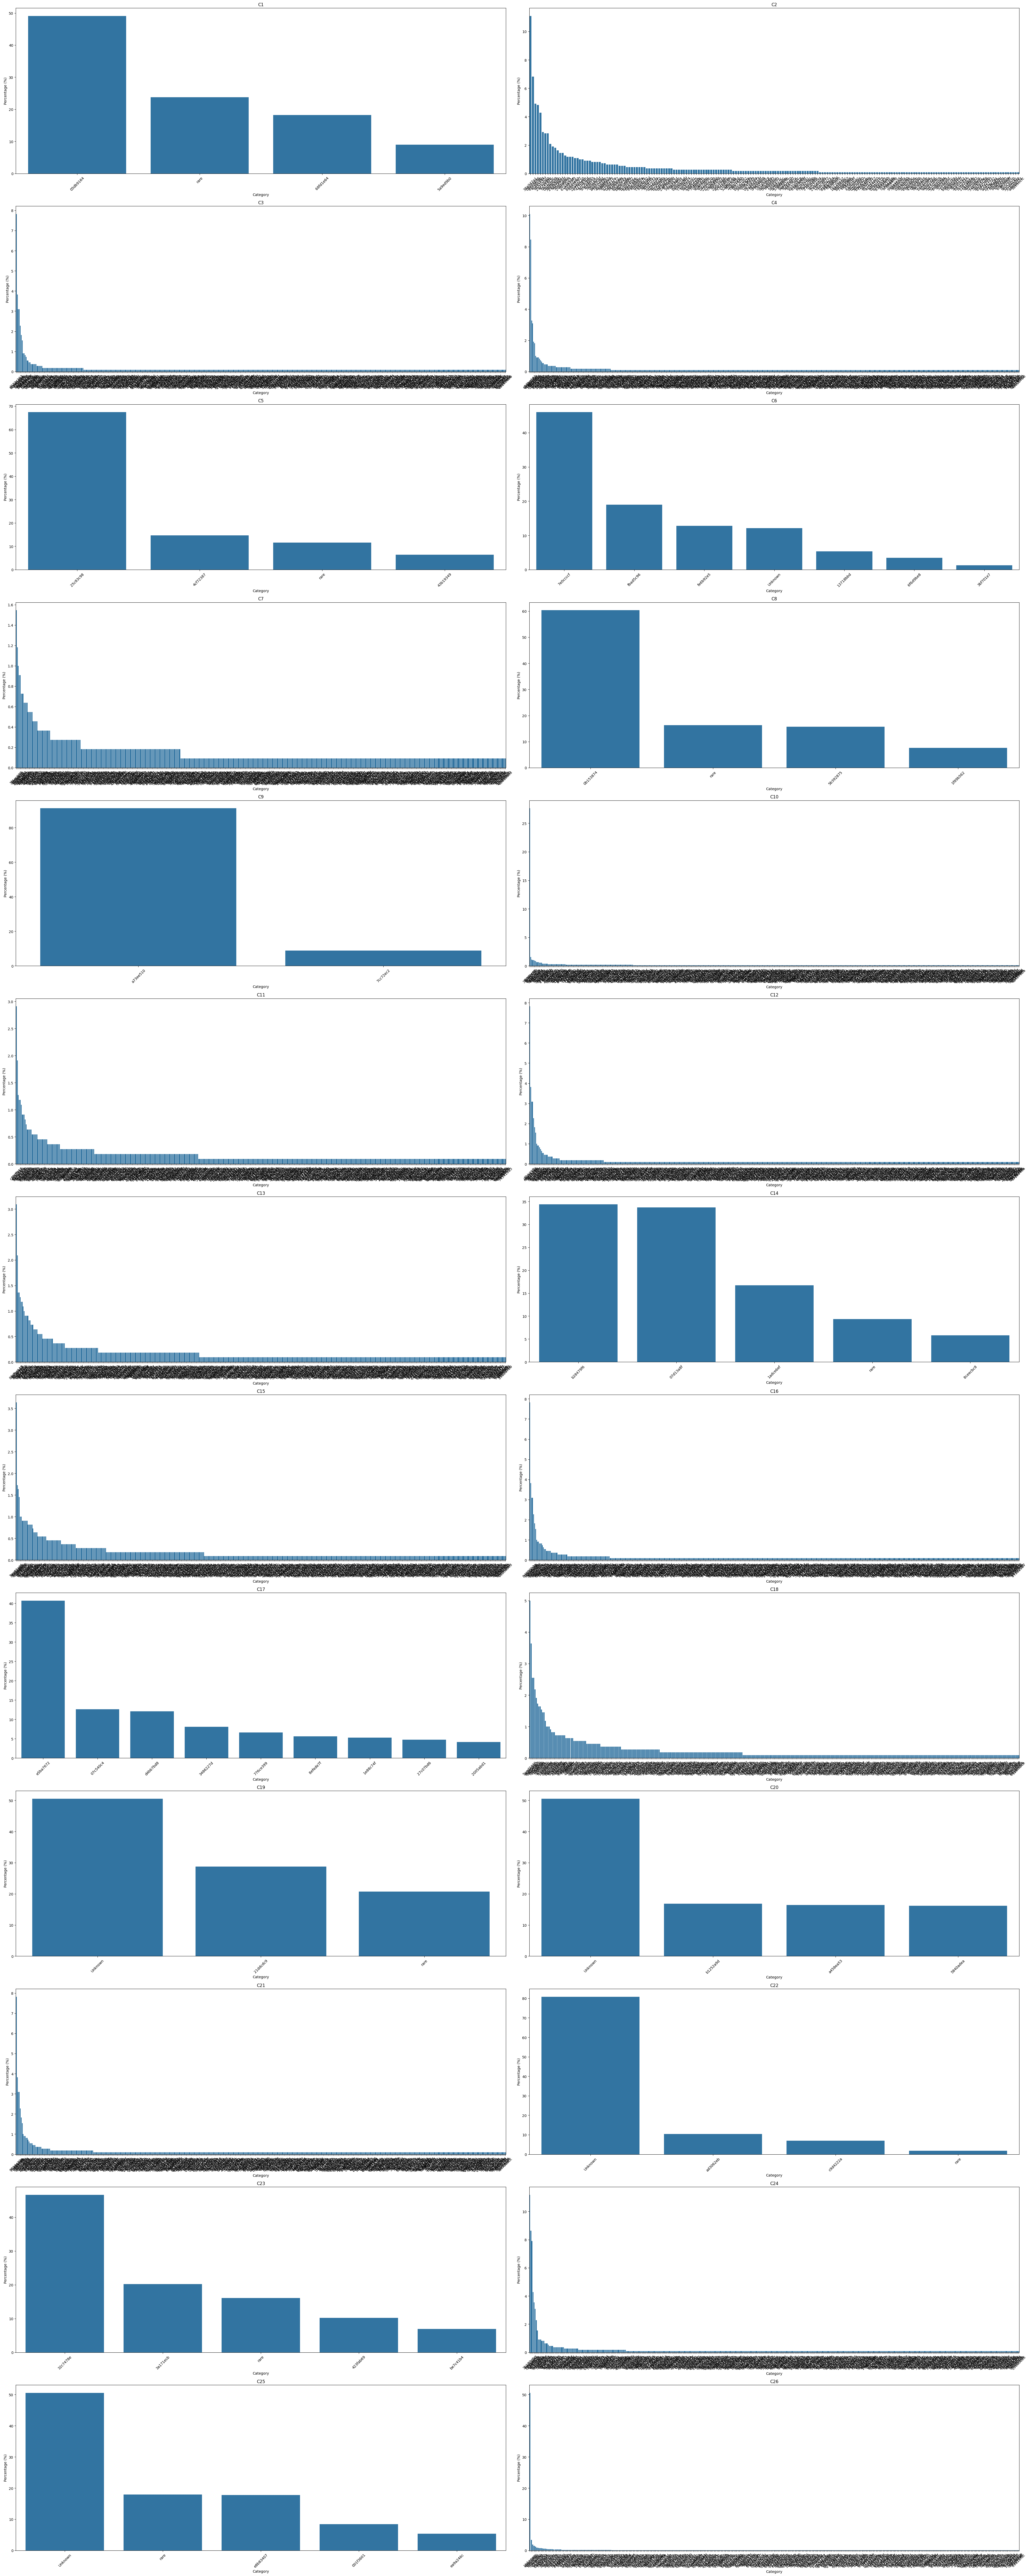

In [52]:
# Define categorical column names
cat_feature_cols = [f"C{i}" for i in range(1, 27)]

# Set up the plot grid
fig, axes = plt.subplots(13, 2, figsize=(40, 100))  # 6x5 grid for 26 categorical features
axes = axes.flatten()

# Plot bar charts for each categorical column
for i, col in enumerate(cat_feature_cols):
    value_counts = df_all[col].value_counts(normalize=True).nlargest(500)  # Get top 100 most frequent categories as percentages
    sns.barplot(x=value_counts.index, y=value_counts.values * 100, ax=axes[i])  # Convert to percentage
    axes[i].set_title(col)
    axes[i].set_xlabel("Category")
    axes[i].set_ylabel("Percentage (%)")
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# Hide any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [49]:
# For the following categorical columns, we need to handle rare subcategories
# -----> Only keep subcategories whose percentage is over 5%

# Define the threshold for rare categories
threshold = 0.05  # 5%

# List of columns with rare cases
columns_with_rare_cases = ["C1", "C5", "C8", "C14", "C19", "C22", "C23", "C25"]

# Process each specified column
for col in columns_with_rare_cases:
    value_counts = df_all[col].value_counts(normalize=True)  # Get percentage of each subcategory
    rare_categories = value_counts[value_counts < threshold].index  # Identify rare subcategories

    # Replace rare subcategories with "rare"
    df_all[col] = df_all[col].replace(rare_categories, "rare")

In [ ]:
# Replace missing values with substring "Unknown"
# Define categorical column names
cat_feature_cols = [f"C{i}" for i in range(1, 27)]
# Replace missing values with "Unknown"
df_all[cat_feature_cols] = df_all[cat_feature_cols].fillna("Unknown")

In [53]:
from sklearn.preprocessing import LabelEncoder

# for all categorical columns, label_encoding:
categorical_cols = [f"C{i}" for i in range(1, 27)] + ["I1","I10","I11","I12"]

# Apply Label Encoding
label_encoders = {}  # Dictionary to store encoders for future transformations

for col in categorical_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col])  # Encode categorical values
    label_encoders[col] = le  # Store the encoder for potential inverse transformations


In [55]:
# display(df_all.info())
# display(df_all.head().T)
# display(df_all.describe().T)
# display(df_all.isnull().sum().T)
# print('all shape:', df_all.shape)

### Train/validation/test data split

In [72]:
# Determine the split index
split_index = int(len(df_all[df_all['label'].notnull()]) * 0.8)
print(f"split_index is {split_index}")

# Train data (Features)
x_train = df_all.loc[df_all['label'].notnull(), :][:split_index]
y_train = x_train['label']
x_train.drop(columns=['label'], inplace=True)
print("x_train shape:", x_train.shape)

# Valid data (Features)
x_val = df_all.loc[df_all['label'].notnull(), :][split_index:]
y_val = x_val['label']
x_val.drop(columns=['label'], inplace=True)
print("x_val shape:", x_val.shape)

# Test data (Features)
x_test = df_all.loc[df_all['label'].isnull(), :]
x_test.drop(columns=['label'], inplace=True)
print("x_test shape:", x_test.shape)

split_index is 800
x_train shape: (800, 39)
x_val shape: (200, 39)
x_test shape: (100, 39)
